In [21]:
import numpy as np
import pandas as pd
import pickle
#import seaborn as sns
import matplotlib.pyplot as plt
import math

In [22]:
#Retrieve pickle object
fileObj = open('data_algos.pkl', 'rb')
all_generations = pickle.load(fileObj)
fileObj.close()

In [23]:
generations_df = pd.DataFrame(all_generations)
generations_df.sample(5)

,radius,generation,fitness,selection_type,pop_size,mutation
1494236,1.640192,230,0.018697,Ranked Selection,90,0.010
688263,1.875029,159,0.018488,Random Selection,80,0.001
1306213,1.683680,280,0.018710,Random Selection,90,0.010
95759,1.683680,317,0.018710,Random Selection,70,0.000
1818675,1.656214,181,0.018705,Random Selection,70,0.050



## Investigation into Population Mean

The utilization of only 8 bits to encode individuals imposes a significant constraint on the range of values we can possibly discover, because of this the optimal solution our algorithm could discover was limited to 1.64705 cm. Recognizing this limitation, we have undertaken a study focusing on the mean of each generated population.

Calculating the mean of the population offers an advantage by allowing us to bypass the minimum step and potentially discover more refined results. Our analysis reveals that the best result, obtained through mean calculation across populations (divided by mutation, generation, population size and selection type), yields a best radius of 1.68382 cm. This result is notably closer to the actual optimal solution of 1.68389 cm.

Consequently, our research now centers on the exploration of population means to gain insights into potentially improved solutions.

In [24]:
def fitness (r):
    ''' 
    Calculates fitness of the proposed radius
    Based on the fitness equation: 1/(2 * (pi) * (r**2) + (60/r))
    Derived from the optimisation problem

    Inputs:
        r       :   Radius -> type = (int, float)

    Outputs
        fitness :   Fitness -> type = (float)
    '''
    #r=d/2
    area = (2 * (math.pi) * (r**2) + (60/r))
    fitness = 1/area
    return fitness

#Calculating best result with populations mean
grouped_pop = generations_df.groupby(by=['mutation', 'generation', 'selection_type', 'pop_size']).mean()

grouped_pop['fitness']=fitness(grouped_pop['radius'])
max_fit_row = grouped_pop.loc[grouped_pop['fitness'].idxmax()]

print("Best population mean:")
print(max_fit_row)

Best population mean:
radius     1.683891
fitness    0.018710
Name: (0.01, 164, Wheel Selection, 50), dtype: float64


## Impact of Population size and Mutation rates on results 

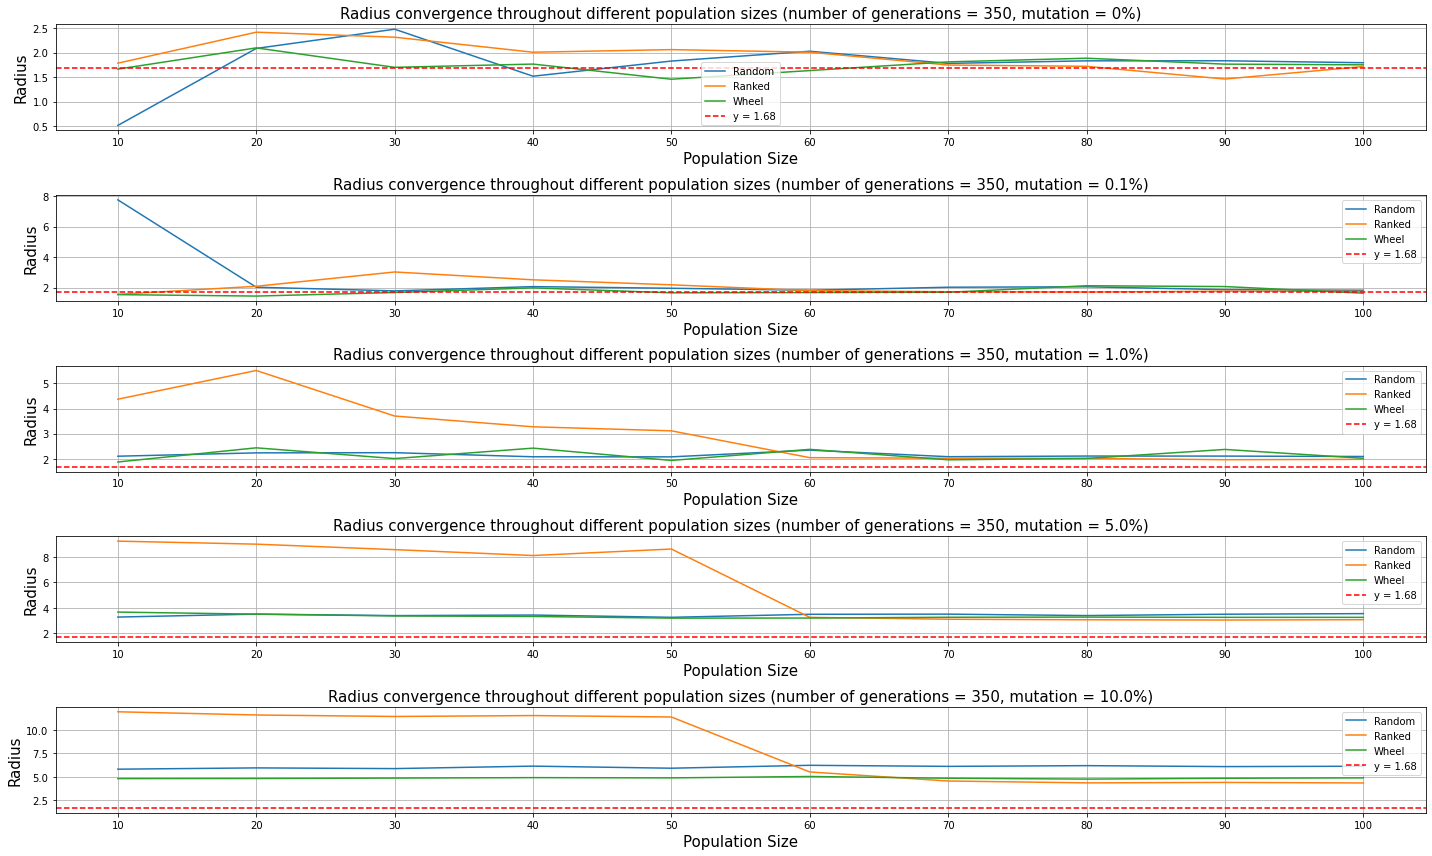

In [25]:
#Visualising the impact of pop_size on results
mutation_rates = [0, 0.001, 0.01, 0.05, 0.1]

# Define a function to create subplots for a given mutation rate
def pop_subplot(mutation_rate, subplot_index):
    mutation_df = generations_df[generations_df['mutation'] == mutation_rate]
    grouped_pop = mutation_df.groupby(by=['selection_type', 'pop_size']).mean()

    num_of_gen=generations_df['generation'].max()+1
    
    gen_size = len(grouped_pop.loc['Random Selection', 'radius'])#defines list of pop_size(s) for plot x-axis labelling
    
    x1 = range(gen_size)
    y1 = grouped_pop.loc['Random Selection', 'radius']
    y2 = grouped_pop.loc['Ranked Selection', 'radius']
    y3 = grouped_pop.loc['Wheel Selection', 'radius']

    plt.subplot(5, 1, subplot_index)
    plt.title(f'Radius convergence throughout different population sizes (number of generations = {num_of_gen}, mutation = {mutation_rate * 100}%)', fontsize=15)
    plt.xlabel('Population Size', fontsize=15)
    plt.ylabel('Radius', fontsize=15)

    plt.plot(x1, y1, label='Random')
    plt.plot(x1, y2, label='Ranked')
    plt.plot(x1, y3, label='Wheel')

    plt.grid()
    plt.axhline(y=1.6841, color='r', linestyle='--', label='y = 1.68')
    plt.legend()

    plt.xticks(range(len(grouped_pop.loc['Random Selection', 'radius'])), labels=grouped_pop.loc['Random Selection', 'radius'].index)


# Create subplots using a for loop
plt.rcParams["figure.figsize"] = (20, 12)
i=1
for mutation_rate in mutation_rates:
    pop_subplot(mutation_rate, i)
    i+=1

plt.tight_layout()
plt.show()


Methods are generally all converging when the population size reaches 60 individuals. Adding more individuals doesn't notably impact the outcome.

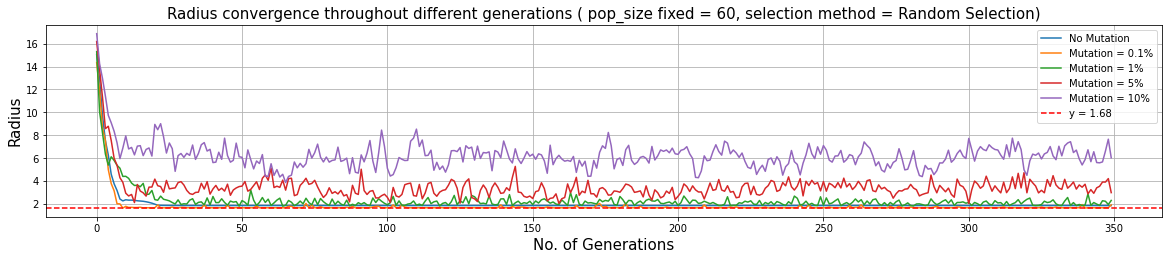

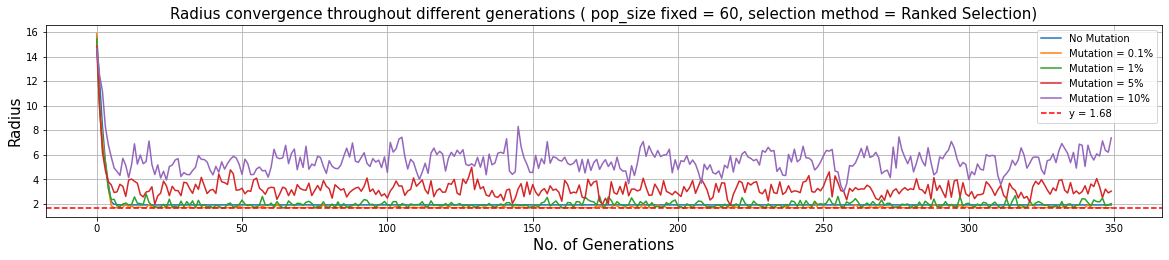

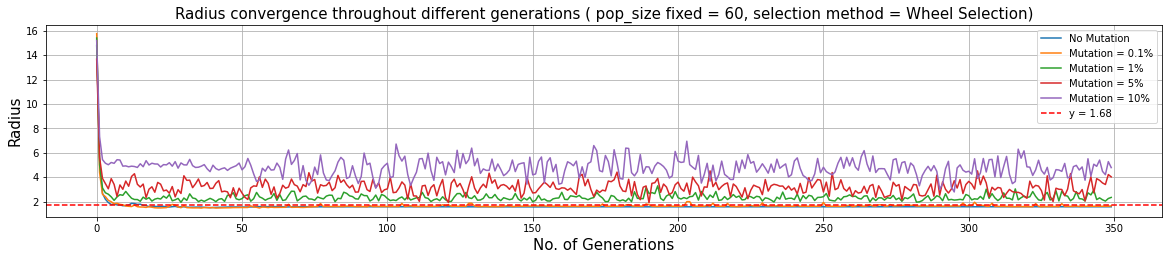

<Figure size 1440x864 with 0 Axes>

In [26]:
#Visualising the results of different mutation rates on the population
#1. Filtering data by optimal population size
ideal_pop_size = 60
mutation_generations_df= generations_df[generations_df['pop_size']== ideal_pop_size]
selection_methods=['Random Selection','Ranked Selection','Wheel Selection']

# Define a function to create subplots for a given selection method
def sel_subplot(selection, subplot_index):
    mutation_generations_method_df= mutation_generations_df[mutation_generations_df['selection_type']==selection]
    grouped_pop = mutation_generations_method_df.groupby(by=['mutation','generation','selection_type']).mean()
    cutoff_point=generations_df['generation'].max()+1

    x1 = range(cutoff_point)
    y1 = (grouped_pop['radius'].values)[:cutoff_point]
    y2 = (grouped_pop['radius'].values)[cutoff_point:2*cutoff_point]
    y3 = (grouped_pop['radius'].values)[2*cutoff_point:3*cutoff_point]
    y4 = (grouped_pop['radius'].values)[3*cutoff_point:4*cutoff_point]
    y5 = (grouped_pop['radius'].values)[4*cutoff_point:]

    plt.subplot(3,1, subplot_index)
    plt.title(f'Radius convergence throughout different generations ( pop_size fixed = {ideal_pop_size}, selection method = {selection})',fontsize=15)
    plt.xlabel('No. of Generations',fontsize=15)
    plt.ylabel('Radius',fontsize=15)

    plt.plot(x1,y1, label = 'No Mutation') 
    plt.plot(x1,y2,label = 'Mutation = 0.1%')
    plt.plot(x1,y3,label = 'Mutation = 1%') 
    plt.plot(x1,y4, label = 'Mutation = 5%')  
    plt.plot(x1,y5, label = 'Mutation = 10%')


    plt.grid()

    plt.axhline(y=1.6841, color='r', linestyle='--', label='y = 1.68')
    #plt.xticks(range(len(grouped_pop.loc['Random Selection', 'radius'])), labels=grouped_pop.loc['Random Selection', 'radius'].index)
    plt.legend()

    plt.show()
    plt.close()
    

# Create subplots using a for loop
plt.rcParams["figure.figsize"] = (20, 12)
i=1
for selection in selection_methods:
    sel_subplot(selection, i)
    i+=1

plt.tight_layout()
plt.show()

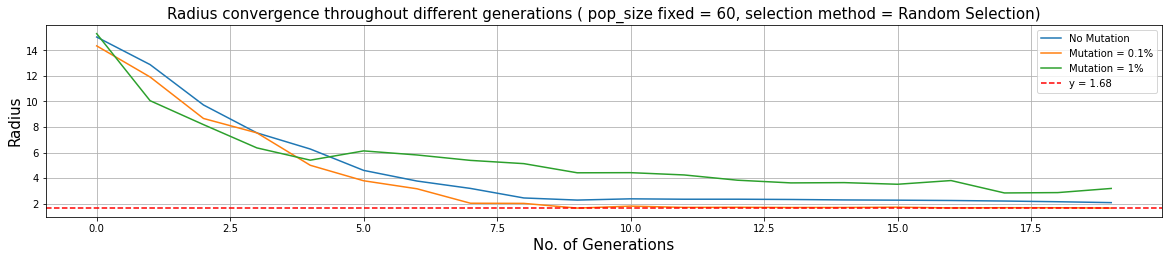

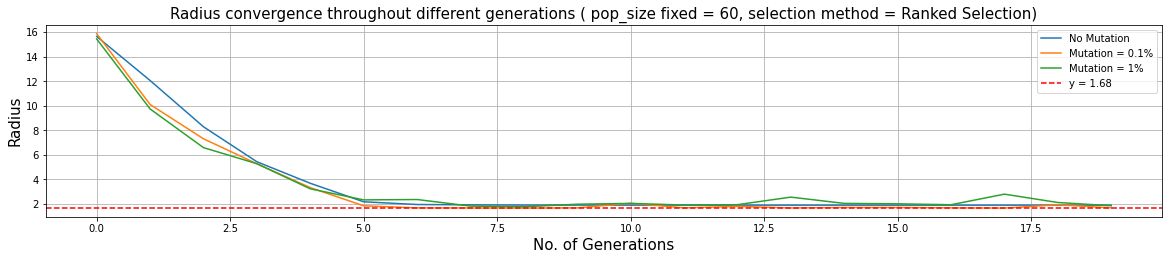

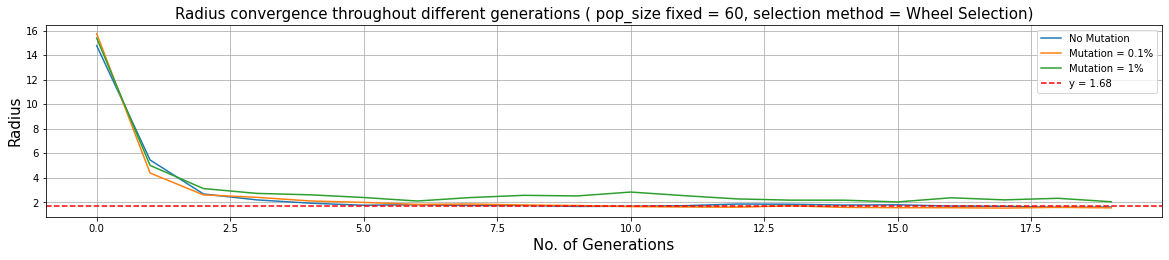

<Figure size 1440x864 with 0 Axes>

In [27]:
#Visualising the results of different mutation rates (5% and 10% excluded )on the population smaller generation window
#1. Filtering data by optimal population size
ideal_pop_size = 60
gen_ideal = 20
mutation_generations_df= generations_df[generations_df['pop_size']== ideal_pop_size]
selection_methods=['Random Selection','Ranked Selection','Wheel Selection']

# Define a function to create subplots for a given selection method
def sel_subplot(selection, subplot_index):
    mutation_generations_method_df= mutation_generations_df[mutation_generations_df['selection_type']==selection]
    grouped_pop = mutation_generations_method_df.groupby(by=['mutation','generation','selection_type']).mean()
    cutoff_point=generations_df['generation'].max()+1

    x1 = range(cutoff_point)
    x1 = x1[:gen_ideal]
    y1 = (grouped_pop['radius'].values)[:cutoff_point]
    y2 = (grouped_pop['radius'].values)[cutoff_point:2*cutoff_point]
    y3 = (grouped_pop['radius'].values)[2*cutoff_point:3*cutoff_point]

    plt.subplot(3,1, subplot_index)
    plt.title(f'Radius convergence throughout different generations ( pop_size fixed = {ideal_pop_size}, selection method = {selection})',fontsize=15)
    plt.xlabel('No. of Generations',fontsize=15)
    plt.ylabel('Radius',fontsize=15)

    plt.plot(x1,y1[:gen_ideal], label = 'No Mutation') 
    plt.plot(x1,y2[:gen_ideal],label = 'Mutation = 0.1%')
    plt.plot(x1,y3[:gen_ideal],label = 'Mutation = 1%') 



    plt.grid()

    plt.axhline(y=1.6841, color='r', linestyle='--', label='y = 1.68')
    plt.legend()

    plt.show()
    plt.close()
    

# Create subplots using a for loop
plt.rcParams["figure.figsize"] = (20, 12)
i=1
for selection in selection_methods:
    sel_subplot(selection, i)
    i+=1

plt.tight_layout()
plt.show()

Mutations exceeding 1% introduce too much variability, becoming counterproductive to the results.

# ERROR ANALYSIS
## Calculating the MSE

In [28]:
ideal_pop_size = 60
solution = 1.6841
mutation_rates = [0, 0.001, 0.01, 0.05, 0.1]
number_of_generations = 20
selection_types = ['Random Selection', 'Ranked Selection', 'Wheel Selection']

generations_df=generations_df[(generations_df['pop_size'] == ideal_pop_size)]

# Dictionary to memorize MSE for each mutation rate and selection type
mse_results = {rate: {sel_type: [] for sel_type in selection_types} for rate in mutation_rates}

for mutation_rate in mutation_rates:
    filtered_generations_df = generations_df[(generations_df['mutation'] == mutation_rate)]

    for selection_type in selection_types:
        selected_df = filtered_generations_df[filtered_generations_df['selection_type'] == selection_type]
        MSES = []

        for k in range(number_of_generations):
            gen_df = selected_df[selected_df['generation'] == k]
            squared_errors = (gen_df['radius'] - solution) ** 2
            MSE = sum(squared_errors) / ideal_pop_size
            MSES.append(MSE)

        mse_results[mutation_rate][selection_type] = MSES

#Seeing the results
for mutation in mutation_rates:
    print(f"Mutation rate {mutation}:")
    for selection in selection_types:
        print(f"{selection} MSE: {mse_results[mutation][selection][-1]} (Gen {number_of_generations})")
    print("\n" + "-"*40 + "\n")


Mutation rate 0:
Random Selection MSE: 0.2104903234657202 (Gen 20)
Ranked Selection MSE: 0.04849946143698235 (Gen 20)
Wheel Selection MSE: 0.0518198238057476 (Gen 20)

----------------------------------------

Mutation rate 0.001:
Random Selection MSE: 0.018541688496641624 (Gen 20)
Ranked Selection MSE: 1.7600031820764018e-07 (Gen 20)
Wheel Selection MSE: 0.10124546876337343 (Gen 20)

----------------------------------------

Mutation rate 0.01:
Random Selection MSE: 10.956185347568882 (Gen 20)
Ranked Selection MSE: 0.6055402194757828 (Gen 20)
Wheel Selection MSE: 0.614190659413571 (Gen 20)

----------------------------------------

Mutation rate 0.05:
Random Selection MSE: 19.70939554437481 (Gen 20)
Ranked Selection MSE: 21.761286463530407 (Gen 20)
Wheel Selection MSE: 15.234669275517726 (Gen 20)

----------------------------------------

Mutation rate 0.1:
Random Selection MSE: 32.3071059647937 (Gen 20)
Ranked Selection MSE: 43.35074357328936 (Gen 20)
Wheel Selection MSE: 425.6949001

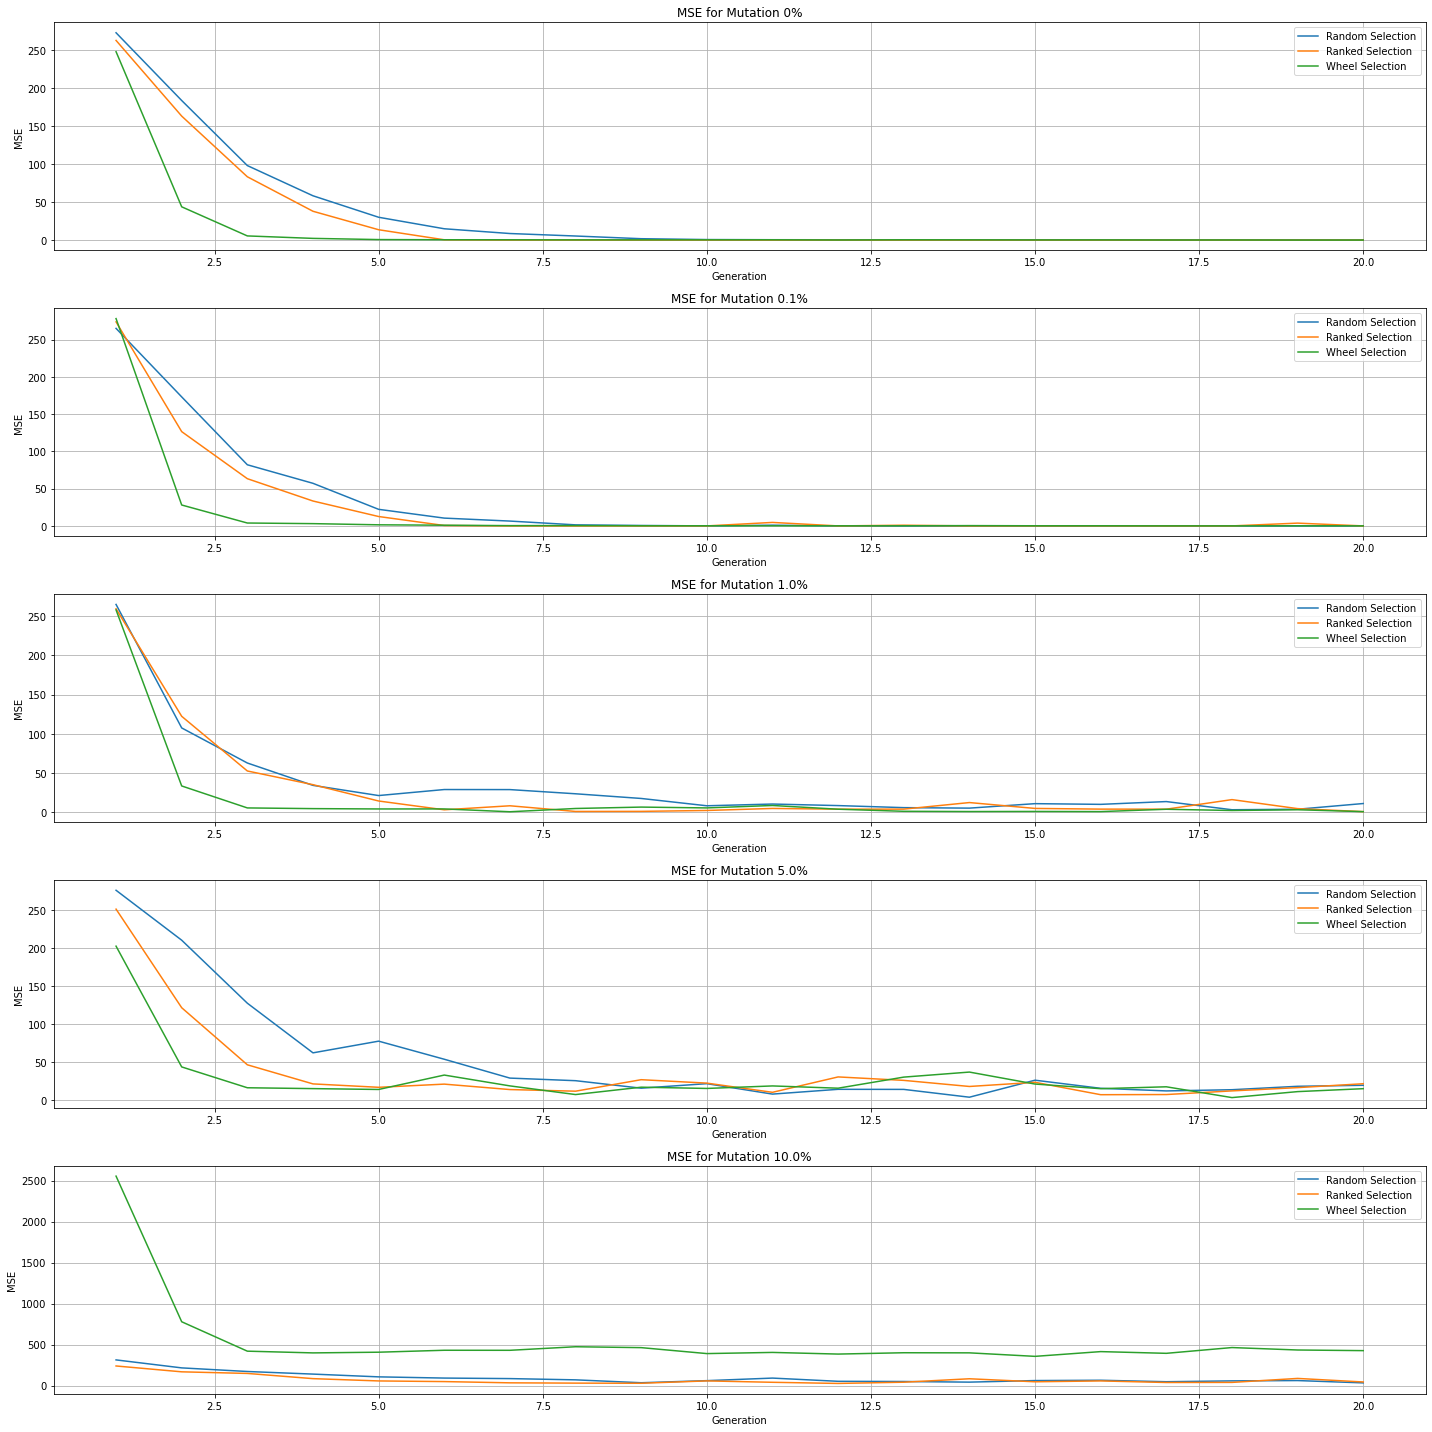

In [29]:
# Plotting the results
plt.rcParams["figure.figsize"] = (20, 20)
i=1
for mutation_rate in mutation_rates:
    plt.subplot(5,1,i)
    plt.plot(range(1, number_of_generations+1), mse_results[mutation_rate]['Random Selection'], label='Random Selection')
    plt.plot(range(1, number_of_generations+1), mse_results[mutation_rate]['Ranked Selection'], label='Ranked Selection')
    plt.plot(range(1, number_of_generations+1), mse_results[mutation_rate]['Wheel Selection'], label='Wheel Selection')

    plt.title(f'MSE for Mutation {mutation_rate*100}%')
    plt.xlabel('Generation')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid()

    i+=1
plt.tight_layout()
plt.show()


# Conclusions

....

In [31]:
#Optimal values
pop_size_op = 60
gen_size_op = 30
n_op = 11
#sel_method_op = (ranked_selection, 'Ranked Selection')
max_rad_op = 30
mutation_rate_op = 0.001